# Prophet - Changepoints

**Import Libraries and datasets**

In [2]:
!pip install prophet
!pip install kats

     |████████████████████████████████| 65 kB 2.1 MB/s 
     |████████████████████████████████| 49 kB 5.5 MB/s 
     |████████████████████████████████| 216 kB 8.5 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6640614 sha256=76ca4b8ddb36592e681084017af07b94513506af61c298bb66e44b1330def0ab
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.
     |████████████████████████████████| 6.3 MB 4.2 MB/s 
     |████████████████████████████████| 866 kB 47.2

In [25]:
#Import Libraries
import pandas as pd
import math
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score,mean_absolute_percentage_error
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.plot import plot_plotly, plot_components_plotly
from kats.consts import TimeSeriesData
from kats.detectors.cusum_detection import CUSUMDetector

In [5]:
pd.set_option("display.max_columns",20)

In [40]:
df = pd.read_excel('/content/drive/MyDrive/Github/m_tech/Datasets/input.xlsx')
df.head()

,Date,SalesVolume
0,1995-01-01,47639.0
1,1995-02-01,47880.0
2,1995-03-01,67025.0
3,1995-04-01,56925.0
4,1995-05-01,64192.0


In [41]:
df = df.dropna()

In [42]:
df.tail()

,Date,SalesVolume
313,2021-02-01,73883.0
314,2021-03-01,102914.0
315,2021-04-01,64632.0
316,2021-05-01,45580.0
317,2021-06-01,41232.0


In [43]:
# synthesize data with simulation
np.random.seed(10)
df_increase_decrease = pd.DataFrame(
    {
        'time': pd.date_range('2019-01-01', periods=60),
        'increase':np.concatenate([np.random.normal(1,0.2,30), np.random.normal(2,0.2,30)]),
        'decrease':np.concatenate([np.random.normal(1,0.3,50), np.random.normal(0.5,0.3,10)]),
    }
)

In [32]:
df_increase_decrease.loc[:,['time','increase']]

,time,increase
0,2019-01-01,1.266317
1,2019-01-02,1.143056
2,2019-01-03,0.690920
3,2019-01-04,0.998323
4,2019-01-05,1.124267
5,2019-01-06,0.855983
6,2019-01-07,1.053102
7,2019-01-08,1.021710
8,2019-01-09,1.000858
9,2019-01-10,0.965080


In [44]:
input_df = df.rename(columns={'Date':'time', 'SalesVolume':'increase'})

In [45]:
tsd = TimeSeriesData(input_df)

In [46]:
tsd

,time,increase
0,1995-01-01,47639.0
1,1995-02-01,47880.0
2,1995-03-01,67025.0
3,1995-04-01,56925.0
4,1995-05-01,64192.0
...,...,...
313,2021-02-01,73883.0
314,2021-03-01,102914.0
315,2021-04-01,64632.0
316,2021-05-01,45580.0


In [35]:
detector = CUSUMDetector(tsd)

In [36]:
change_points = detector.detector(interest_window=[20,40])

In [37]:
change_points

[(TimeSeriesChangePoint(start_time: 2019-01-30 00:00:00, end_time: 2019-01-30 00:00:00, confidence: 1.0),
  <kats.detectors.cusum_detection.CUSUMMetadata at 0x7f34b7440610>)]

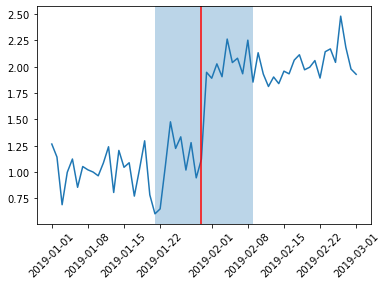

In [38]:
plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

[WARNING 12-09 16:25:38] ax.core.parameter: `sort_values` is not specified for `ChoiceParameter` "known_prec_multiplier". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.
[WARNING 12-09 16:25:38] ax.core.parameter: `sort_values` is not specified for `ChoiceParameter` "cp_prior". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.
[WARNING 12-09 16:25:38] ax.core.parameter: `sort_values` is not specified for `ChoiceParameter` "known_prec_multiplier". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.
[WARNING 12-09 16:25:38] ax.core.parameter: `sort_values` is not specified for `ChoiceParameter` "cp_prior". Defaulting to `T

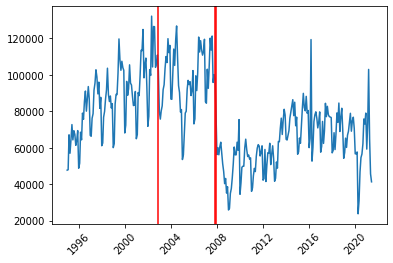

In [47]:
from kats.detectors.bocpd import BOCPDetector, BOCPDModelType, TrendChangeParameters

# Initialize the detector
detector = BOCPDetector(tsd)


changepoints = detector.detector(
    model=BOCPDModelType.NORMAL_KNOWN_MODEL # this is the default choice
)

# Plot the data
plt.xticks(rotation=45)
detector.plot(changepoints)
plt.show()

In [48]:
# import package
from kats.detectors.robust_stat_detection import RobustStatDetector

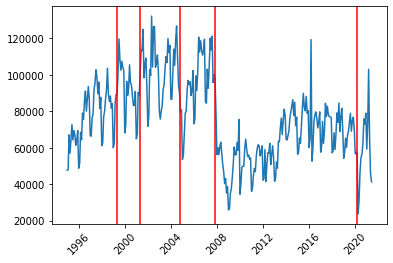

In [49]:
detector = RobustStatDetector(tsd)
change_points = detector.detector()

plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

**Model training and Prediction**

In [ ]:
input_df = df[:311].rename(columns={'Date':'ds', 'SalesVolume':'y'})
input_df.tail(10)

,ds,y
301,2020-02-01,56568.0
302,2020-03-01,57626.0
303,2020-04-01,23673.0
304,2020-05-01,30798.0
305,2020-06-01,46664.0
306,2020-07-01,54524.0
307,2020-08-01,56476.0
308,2020-09-01,62122.0
309,2020-10-01,75744.0
310,2020-11-01,72973.0


In [ ]:
#Train and fit the model
def model_train_predict(input_df,params):
  m = Prophet( seasonality_mode='additive', 
            yearly_seasonality= True,
            daily_seasonality = False,
            weekly_seasonality = False,
            **params)
  m.fit(input_df)
  # Forcasting into the future
  future = m.make_future_dataframe(periods=9,freq='MS')
  forecast = m.predict(future)
  return m, forecast

In [ ]:
default_params = {  
    'changepoint_prior_scale': 0.05,
    'changepoint_range' : 0.8,
    'seasonality_prior_scale': 10.0,
}

In [ ]:
model , forecast = model_train_predict(input_df,default_params)

In [ ]:
#Parameters for the model
model.component_modes

{'additive': ['yearly',
  'additive_terms',
  'extra_regressors_additive',
  'holidays'],
 'multiplicative': ['multiplicative_terms', 'extra_regressors_multiplicative']}

In [ ]:
# Plot the predictions
def viz_plot(m,forecast):
  fig = plot_plotly(m, forecast)
  fig.show()
  fig2 = plot_components_plotly(m, forecast)
  fig2.show()

In [ ]:
viz_plot(model , forecast)

# Cross Validation

In [ ]:
cutoffs = pd.date_range(start='2000-01-01', end='2020-06-01', freq='2MS')
cutoffs

DatetimeIndex(['2000-01-01', '2000-03-01', '2000-05-01', '2000-07-01',
               '2000-09-01', '2000-11-01', '2001-01-01', '2001-03-01',
               '2001-05-01', '2001-07-01',
               ...
               '2018-11-01', '2019-01-01', '2019-03-01', '2019-05-01',
               '2019-07-01', '2019-09-01', '2019-11-01', '2020-01-01',
               '2020-03-01', '2020-05-01'],
              dtype='datetime64[ns]', length=123, freq='2MS')

In [ ]:
df_cv = cross_validation(m, horizon = '90 days', cutoffs = cutoffs, parallel="processes")

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f589c2fdb90>


In [ ]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,30 days,2.910045e+08,17058.853778,13401.689062,0.184035,0.125805,0.186329,0.425000
1,31 days,2.399266e+08,15489.563299,11510.292304,0.190732,0.125376,0.183225,0.554217
2,59 days,2.264334e+08,15047.702506,11468.712455,0.181853,0.129237,0.186315,0.619092
3,60 days,3.257181e+08,18047.663001,13158.441363,0.197805,0.121786,0.197773,0.606580
4,61 days,2.886918e+08,16990.933532,13294.534115,0.216816,0.147793,0.215720,0.390244


In [ ]:
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,30 days,2.910045e+08,17058.853778,13401.689062,0.184035,0.125805,0.186329,0.425000
1,31 days,2.399266e+08,15489.563299,11510.292304,0.190732,0.125376,0.183225,0.554217
2,59 days,2.264334e+08,15047.702506,11468.712455,0.181853,0.129237,0.186315,0.619092
3,60 days,3.257181e+08,18047.663001,13158.441363,0.197805,0.121786,0.197773,0.606580
4,61 days,2.886918e+08,16990.933532,13294.534115,0.216816,0.147793,0.215720,0.390244
5,62 days,2.763256e+08,16623.043885,12987.138072,0.202897,0.115046,0.195296,0.436210
6,90 days,2.360245e+08,15363.090020,12395.217558,0.193321,0.137714,0.201756,0.536538


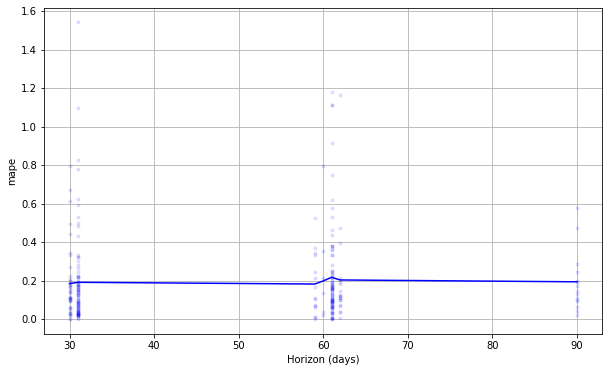

In [ ]:
fig = plot_cross_validation_metric(df_cv, metric='mape')


### **Evaluation Metrics**

In [ ]:
def evaluation_metrics(forecast):
  metric_df = forecast[['ds','yhat']][311:318]
  metric_df['Actual'] = df['SalesVolume'][311:318]
  mae = mean_absolute_error(metric_df['yhat'], metric_df['Actual'])
  mape = mean_absolute_percentage_error(metric_df['yhat'], metric_df['Actual'])
  rmse = math.sqrt(mean_squared_error(metric_df['yhat'], metric_df['Actual']))
  print("Mean absolute error:", mae)
  print("Mean absolute percentage error:", mape)
  print("Root mean squared error:", rmse)

In [ ]:
evaluation_metrics(forecast)

Mean absolute error: 25051.838225694053
Mean absolute percentage error: 0.5502995953301949
Root mean squared error: 28340.851543347097


### **Hyper-Paramter Tuning**

**Tunable Parameters:**

***changepoint_prior_scale (Trend):*** 

This is probably the most impactful parameter. It determines the flexibility of the trend, and in particular how much the trend changes at the trend changepoints. As described in this documentation, if it is too small, the trend will be underfit and variance that should have been modeled with trend changes will instead end up being handled with the noise term. If it is too large, the trend will overfit and in the most extreme case you can end up with the trend capturing yearly seasonality. The default of 0.05 works for many time series, but this could be tuned; a range of [0.001, 0.5] would likely be about right. Parameters like this (regularization penalties; this is effectively a lasso penalty) are often tuned on a log scale.

***changepoint_range (Trend):*** 

This is the proportion of the history in which the trend is allowed to change. This defaults to 0.8, 80% of the history, meaning the model will not fit any trend changes in the last 20% of the time series. This is fairly conservative, to avoid overfitting to trend changes at the very end of the time series where there isn’t enough runway left to fit it well. With a human in the loop, this is something that can be identified pretty easily visually: one can pretty clearly see if the forecast is doing a bad job in the last 20%. In a fully-automated setting, it may be beneficial to be less conservative. It likely will not be possible to tune this parameter effectively with cross validation over cutoffs as described above. The ability of the model to generalize from a trend change in the last 10% of the time series will be hard to learn from looking at earlier cutoffs that may not have trend changes in the last 10%. So, this parameter is probably better not tuned, except perhaps over a large number of time series. In that setting, [0.8, 0.95] may be a reasonable range.

***seasonality_prior_scale:*** 

This parameter controls the flexibility of the seasonality. Similarly, a large value allows the seasonality to fit large fluctuations, a small value shrinks the magnitude of the seasonality. The default is 10., which applies basically no regularization. That is because we very rarely see overfitting here (there’s inherent regularization with the fact that it is being modeled with a truncated Fourier series, so it’s essentially low-pass filtered). A reasonable range for tuning it would probably be [0.01, 10]; when set to 0.01 you should find that the magnitude of seasonality is forced to be very small. This likely also makes sense on a log scale, since it is effectively an L2 penalty like in ridge regression.

***holidays_prior_scale:***

This controls flexibility to fit holiday effects. Similar to seasonality_prior_scale, it defaults to 10.0 which applies basically no regularization, since we usually have multiple observations of holidays and can do a good job of estimating their effects. This could also be tuned on a range of [0.01, 10] as with seasonality_prior_scale.

In [ ]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.4],
    'changepoint_range' : [0.8, 0.82, 0.85,0.9,0.92],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 5.0, 9.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
maes = []  # Store the mae for each params here
mapes = []  # Store the mape for each params here
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    print(params)
    m = Prophet( daily_seasonality = False,
                weekly_seasonality = False, 
                **params).fit(input_df)  # Fit model with given params
    future = m.make_future_dataframe(periods=9,freq='MS')
    forecast = m.predict(future)
    metric_df = forecast[['ds','yhat']][311:318]
    metric_df['Actual'] = df['SalesVolume'][311:318]
    mae = mean_absolute_error(metric_df['yhat'], metric_df['Actual'])
    mape = mean_absolute_percentage_error(metric_df['yhat'], metric_df['Actual'])
    rmse = math.sqrt(mean_squared_error(metric_df['yhat'], metric_df['Actual']))
    maes.append(mae)
    mapes.append(mape)
    rmses.append(rmse)

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = maes
tuning_results['mape'] = mapes
tuning_results['rmse'] = rmses

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'seasonality_prior_scale': 0.01}
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'seasonality_prior_scale': 0.1}
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'seasonality_prior_scale': 1.0}
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'seasonality_prior_scale': 5.0}
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'seasonality_prior_scale': 9.0}
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.82, 'seasonality_prior_scale': 0.01}
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.82, 'seasonality_prior_scale': 0.1}
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.82, 'seasonality_prior_scale': 1.0}
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.82, 'seasonality_prior_scale': 5.0}
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.82, 'seasonality_prior_scale': 9.0}
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.85, '

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'seasonality_prior_scale': 1.0}
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'seasonality_prior_scale': 5.0}
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'seasonality_prior_scale': 9.0}
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.92, 'seasonality_prior_scale': 0.01}
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.92, 'seasonality_prior_scale': 0.1}
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.92, 'seasonality_prior_scale': 1.0}
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.92, 'seasonality_prior_scale': 5.0}
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.92, 'seasonality_prior_scale': 9.0}
{'changepoint_prior_scale': 0.4, 'changepoint_range': 0.8, 'seasonality_prior_scale': 0.01}
{'changepoint_prior_scale': 0.4, 'changepoint_range': 0.8, 'seasonality_prior_scale': 0.1}
{'changepoint_prior_scale': 0.4, 'changepoint_range': 0.8, 'seasonality_prior_scale

In [ ]:
best_params = all_params[np.argmin(maes)]
print(best_params)

In [ ]:
tuning_results.sort_values('mae').head()

### **Predicting with the best params**

In [ ]:
model , forecast = model_train_predict(input_df,best_params)

In [ ]:
viz_plot(model , forecast)

In [ ]:
evaluation_metrics(forecast)